In [15]:
import pandas as pd
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Auto select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------------------------------------------------
# Load metadata
# ---------------------------------------------------
with open("/kaggle/input/cub2002011/CUB_200_2011/train_test_split.txt") as f:
    split = dict(line.strip().split() for line in f)

with open("/kaggle/input/cub2002011/CUB_200_2011/images.txt") as f:
    paths = dict(line.strip().split() for line in f)

with open("/kaggle/input/cub2002011/CUB_200_2011/image_class_labels.txt") as f:
    labels = dict(line.strip().split() for line in f)

# ---------------------------------------------------
# Select only FIRST 5 classes
# ---------------------------------------------------
selected_classes = set(list({int(v) for v in labels.values()})[:200])

print("Using classes:", selected_classes)

train_paths, train_labels = [], []
test_paths, test_labels = [], []

base = "/kaggle/input/cub2002011/CUB_200_2011/images/"

for img_id, rel in paths.items():
    cls = int(labels[img_id])
    if cls not in selected_classes:
        continue

    full = base + rel
    if split[img_id] == "1":
        train_paths.append(full)
        train_labels.append(cls)
    else:
        test_paths.append(full)
        test_labels.append(cls)

print("Train images:", len(train_paths))
print("Test images :", len(test_paths))

# ---------------------------------------------------
# Convert to DataFrames (path + class)
# ---------------------------------------------------
train_df = pd.DataFrame({"path": train_paths, "class": train_labels})
test_df  = pd.DataFrame({"path": test_paths , "class": test_labels})

# ---------------------------------------------------
# Per-class sample counts
# ---------------------------------------------------

train_count = train_df["class"].value_counts().sort_index()
test_count  = test_df["class"].value_counts().sort_index()

print("\n===== TRAIN PER-CLASS COUNTS =====")
print(train_count)

print("\n===== TEST PER-CLASS COUNTS =====")
print(test_count)

print("\n===== SUMMARY =====")
print("Train: classes =", train_count.index.nunique(),
      "| min =", train_count.min(),
      "| max =", train_count.max(),
      "| avg =", train_count.mean())

print("Test : classes =", test_count.index.nunique(),
      "| min =", test_count.min(),
      "| max =", test_count.max(),
      "| avg =", test_count.mean())

# ---------------------------------------------------
# Dataset class with transforms
# ---------------------------------------------------
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

class CUBDataset(Dataset):
    def __init__(self, df, transform):
        self.paths = df["path"].values
        self.labels = df["class"].values
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transform(img)
        cls = self.labels[idx] - 1
        return img, cls

# ---------------------------------------------------
# Dataloaders
# ---------------------------------------------------
train_dataset = CUBDataset(train_df, transform_train)
test_dataset = CUBDataset(test_df, transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset , batch_size=32, shuffle=False, num_workers=2)

print("Train loader batches:", len(train_loader))
print("Test loader batches :", len(test_loader))

Using device: cuda
Using classes: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200}
Train images: 5994
Test images : 5794

===== TRAIN PER-CLASS COUNTS =====

Epoch 1/10  Loss = 0.6427
Epoch 2/10  Loss = 0.4866
Epoch 3/10  Loss = 0.4381
Epoch 4/10  Loss = 0.4754
Epoch 5/10  Loss = 0.4769
Epoch 6/10  Loss = 0.4557
Epoch 7/10  Loss = 0.4410
Epoch 8/10  Loss = 0.4561
Epoch 9/10  Loss = 0.4833
Epoch 10/10  Loss = 0.4152

========== METRIC LEARNING EVALUATION ==========
Recall@1 = 0.17759751467034865
Recall@2 = 0.2694166379012772
Recall@4 = 0.3743527787366241
Recall@8 = 0.511391094235416

NMI = 0.5152087071989684
F1  = 0.004424379105272763

Pairwise Precision = 0.009897997130093188
Pairwise Recall    = 0.9798879386611562


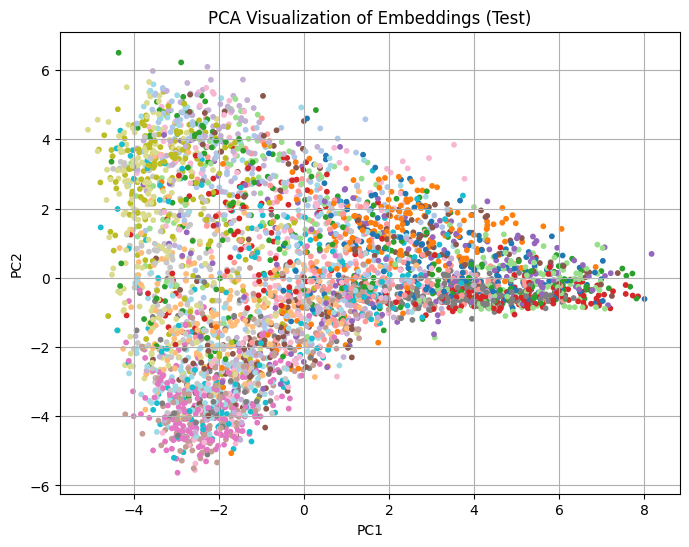

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, f1_score
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ===============================================================
#   SIMPLE ENCODER–DECODER MODEL (NO DVML)
# ===============================================================
class SimpleMetricAutoEncoder(nn.Module):
    def __init__(self, embed_dim=512):
        super().__init__()

        goog = models.googlenet(weights="IMAGENET1K_V1")

        self.backbone = nn.Sequential(
            goog.conv1, goog.maxpool1,
            goog.conv2, goog.conv3, goog.maxpool2,
            goog.inception3a, goog.inception3b, goog.maxpool3,
            goog.inception4a, goog.inception4b, goog.inception4c,
            goog.inception4d, goog.inception4e,
            goog.maxpool4,
            goog.inception5a, goog.inception5b,
            goog.avgpool
        )

        self.fc_embed = nn.Linear(1024, embed_dim)

        self.decoder = nn.Sequential(
            nn.Linear(embed_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024)
        )

    def extract_f(self, x):
        f = self.backbone(x)
        return f.view(f.size(0), -1)

    def forward(self, x):
        f = self.extract_f(x)
        z = self.fc_embed(f)
        f_hat = self.decoder(z)
        return z, f, f_hat


# ===============================================================
#   N-PAIR LOSS
# ===============================================================
class NPairLoss(nn.Module):
    def forward(self, A, P):
        A = F.normalize(A, dim=1)
        P = F.normalize(P, dim=1)
        sim = A @ P.t()
        lbl = torch.arange(len(A), device=sim.device)
        return F.cross_entropy(sim, lbl)


def recon_loss(f, f_hat):
    return F.mse_loss(f_hat, f)


# ===============================================================
#   MODEL INIT
# ===============================================================
model = SimpleMetricAutoEncoder(embed_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
npair = NPairLoss()


# ===============================================================
#   TRAIN LOOP
# ===============================================================
loss_list = []
EPOCHS = 10   # ← SET EPOCH COUNT HERE

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        z, f, f_hat = model(imgs)

        # Build N-pair A,P pairs
        A, P = [], []
        for c in labels.unique():
            idx = (labels == c).nonzero().flatten()
            if len(idx) >= 2:
                A.append(z[idx[0]])
                P.append(z[idx[1]])

        if len(A) == 0:
            continue

        A = torch.stack(A)
        P = torch.stack(P)

        loss = npair(A, P) + recon_loss(f, f_hat)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    loss_list.append(epoch_loss)

    print(f"Epoch {epoch+1}/{EPOCHS}  Loss = {epoch_loss:.4f}")


# ===============================================================
#   EXTRACT EMBEDDINGS
# ===============================================================
def extract_embeddings(model, loader):
    E, L = [], []
    model.eval()

    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            z, _, _ = model(imgs)
            E.append(z.cpu())
            L.append(lbls.cpu())

    return torch.cat(E), torch.cat(L)


# ===============================================================
#   EVALUATION METRICS
# ===============================================================
def recall_at_k(E, L, K=1):
    E = F.normalize(E, dim=1)
    sim = E @ E.t()

    N = len(L)
    sim[range(N), range(N)] = -1

    _, idx = sim.topk(K, dim=1)
    return sum(L[i] in L[idx[i]] for i in range(N)) / N


def clustering_metrics(E, L, num_classes):
    km = KMeans(n_clusters=num_classes, n_init=10)
    clusters = km.fit_predict(E)
    nmi = normalized_mutual_info_score(L, clusters)
    f1 = f1_score(L, clusters, average="macro")
    return nmi, f1


def pairwise_precision_recall(E, L):
    D = pairwise_distances(E)
    y_true = (L[:, None] == L[None, :]).astype(int)
    thr = np.median(D)
    y_pred = (D < thr).astype(int)

    TP = (y_pred * y_true).sum()
    FP = (y_pred * (1 - y_true)).sum()
    FN = ((1 - y_pred) * y_true).sum()

    prec = TP / (TP + FP + 1e-9)
    rec  = TP / (TP + FN + 1e-9)
    return prec, rec


# ===============================================================
#   RUN EVALUATION
# ===============================================================
E, L = extract_embeddings(model, test_loader)
num_classes = len(torch.unique(L))

print("\n========== METRIC LEARNING EVALUATION ==========")
for k in [1,2,4,8]:
    print(f"Recall@{k} =", recall_at_k(E, L, k))

nmi, f1 = clustering_metrics(E.numpy(), L.numpy(), num_classes)
print("\nNMI =", nmi)
print("F1  =", f1)

prec, rec = pairwise_precision_recall(E.numpy(), L.numpy())
print("\nPairwise Precision =", prec)
print("Pairwise Recall    =", rec)


# ===============================================================
#   PCA VISUALIZATION
# ===============================================================
def plot_pca_clusters(E, L, num_samples=4000):
    E = E.numpy()
    L = L.numpy()

    if len(E) > num_samples:
        idx = np.random.choice(len(E), num_samples, replace=False)
        E = E[idx]
        L = L[idx]

    X = PCA(n_components=2).fit_transform(E)

    plt.figure(figsize=(8,6))
    plt.scatter(X[:,0], X[:,1], c=L, cmap="tab20", s=10)
    plt.title("PCA Visualization of Embeddings (Test)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.show()


plot_pca_clusters(E, L)

Using device: cuda
Using classes: 200
Train batches: 188
Test  batches: 182


Epoch 1/10: 100%|██████████| 188/188 [00:26<00:00,  7.00it/s]


Epoch 01 | Avg loss: 3.3669


Epoch 2/10: 100%|██████████| 188/188 [00:27<00:00,  6.89it/s]


Epoch 02 | Avg loss: 3.2761


Epoch 3/10: 100%|██████████| 188/188 [00:26<00:00,  7.04it/s]


Epoch 03 | Avg loss: 3.2738


Epoch 4/10: 100%|██████████| 188/188 [00:26<00:00,  7.03it/s]


Epoch 04 | Avg loss: 3.2409


Epoch 5/10: 100%|██████████| 188/188 [00:26<00:00,  6.99it/s]


Epoch 05 | Avg loss: 3.2398


Epoch 6/10: 100%|██████████| 188/188 [00:26<00:00,  6.98it/s]


Epoch 06 | Avg loss: 3.2442


Epoch 7/10: 100%|██████████| 188/188 [00:26<00:00,  7.01it/s]


Epoch 07 | Avg loss: 3.2185


Epoch 8/10: 100%|██████████| 188/188 [00:26<00:00,  7.00it/s]


Epoch 08 | Avg loss: 3.2212


Epoch 9/10: 100%|██████████| 188/188 [00:26<00:00,  7.00it/s]


Epoch 09 | Avg loss: 3.2303


Epoch 10/10: 100%|██████████| 188/188 [00:26<00:00,  7.00it/s]

Epoch 10 | Avg loss: 3.1958



========== METRIC LEARNING EVALUATION ==========
Recall@1 = 0.1949
Recall@2 = 0.2903
Recall@4 = 0.4049
Recall@8 = 0.5418

NMI = 0.5130517163049599
F1  = 0.008956324467289696

Pairwise Precision = 0.00992885644128738
Pairwise Recall     = 0.9829430846357949


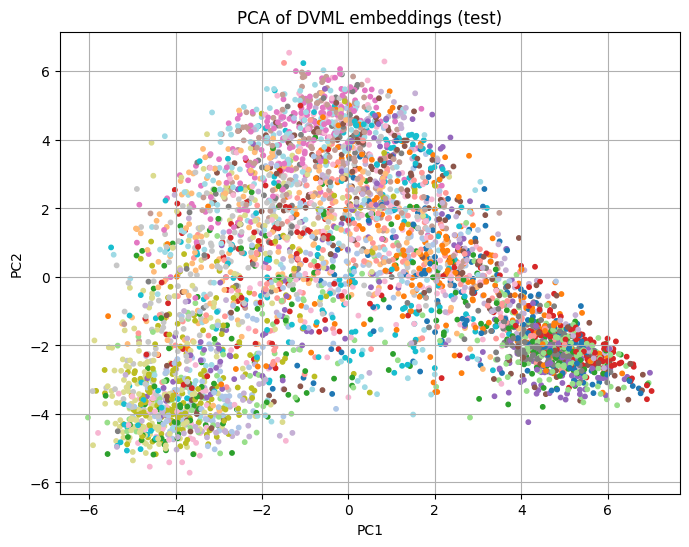

In [18]:
# --------------------------------------------------------------
# 1. Imports & device
# --------------------------------------------------------------
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from tqdm import tqdm
import random
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, f1_score, pairwise_distances
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --------------------------------------------------------------
# 2. Load metadata (your original code – unchanged)
# --------------------------------------------------------------
with open("/kaggle/input/cub2002011/CUB_200_2011/train_test_split.txt") as f:
    split = dict(line.strip().split() for line in f)
with open("/kaggle/input/cub2002011/CUB_200_2011/images.txt") as f:
    paths = dict(line.strip().split() for line in f)
with open("/kaggle/input/cub2002011/CUB_200_2011/image_class_labels.txt") as f:
    labels = dict(line.strip().split() for line in f)

# --------------------------------------------------------------
# 3. Select first 200 classes
# --------------------------------------------------------------
selected_classes = set(list({int(v) for v in labels.values()})[:200])
print("Using classes:", len(selected_classes))

train_paths, train_labels = [], []
test_paths,  test_labels  = [], []
base = "/kaggle/input/cub2002011/CUB_200_2011/images/"

for img_id, rel in paths.items():
    cls = int(labels[img_id])
    if cls not in selected_classes: continue
    full = base + rel
    if split[img_id] == "1":
        train_paths.append(full); train_labels.append(cls)
    else:
        test_paths.append(full);  test_labels.append(cls)

train_df = pd.DataFrame({"path": train_paths, "class": train_labels})
test_df  = pd.DataFrame({"path": test_paths , "class": test_labels})

# --------------------------------------------------------------
# 4. Transforms & Dataset (unchanged)
# --------------------------------------------------------------
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

class CUBDataset(Dataset):
    def __init__(self, df, transform):
        self.paths  = df["path"].values
        self.labels = df["class"].values
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transform(img)
        cls = self.labels[idx] - 1               # 0-based
        return img, cls

train_dataset = CUBDataset(train_df, transform_train)
test_dataset  = CUBDataset(test_df , transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True , num_workers=2)
test_loader  = DataLoader(test_dataset , batch_size=32, shuffle=False, num_workers=2)

print("Train batches:", len(train_loader))
print("Test  batches:", len(test_loader))

# --------------------------------------------------------------
# 5. DVML network (exactly as in the paper)
# --------------------------------------------------------------
class DVML(nn.Module):
    def __init__(self, embed_dim=128, T=20):
        super().__init__()
        # ---- backbone (GoogleNet up to avg-pool) ----
        goog = models.googlenet(weights="IMAGENET1K_V1")
        self.backbone = nn.Sequential(
            goog.conv1, goog.maxpool1,
            goog.conv2, goog.conv3, goog.maxpool2,
            goog.inception3a, goog.inception3b, goog.maxpool3,
            goog.inception4a, goog.inception4b, goog.inception4c,
            goog.inception4d, goog.inception4e,
            goog.maxpool4,
            goog.inception5a, goog.inception5b,
            goog.avgpool
        )
        # ---- intra-class invariance (class centre) ----
        self.fc_I = nn.Linear(1024, embed_dim)               # z_I
        # ---- variational part (μ, logσ²) ----
        self.fc_mu    = nn.Linear(1024, embed_dim)
        self.fc_logvar= nn.Linear(1024, embed_dim)
        # ---- decoder: reconstruct the 1024-dim backbone feature ----
        self.decoder = nn.Sequential(
            nn.Linear(embed_dim, 512), nn.ReLU(),
            nn.Linear(512, 1024)
        )
        self.T = T
        self.embed_dim = embed_dim

    def encode(self, x):
        f = self.backbone(x).view(x.size(0), -1)            # (B,1024)
        z_I = self.fc_I(f)
        mu    = self.fc_mu(f)
        logvar= self.fc_logvar(f)
        return z_I, mu, logvar, f

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)                        # (B,D)
        return mu + eps * std                              # z_V

    def forward(self, x, train=True):
        z_I, mu, logvar, f = self.encode(x)                # (B,D), (B,D), (B,D), (B,1024)

        if not train:                                      # inference → only z_I
            f_hat = self.decoder(z_I)
            return z_I, f, f_hat

        # ---- sample T variance vectors per image ----
        z_V = self.reparameterize(mu, logvar)              # (B,D)
        z_V = z_V.unsqueeze(1).repeat(1, self.T, 1)        # (B,T,D)
        z_I_rep = z_I.unsqueeze(1).repeat(1, self.T, 1)    # (B,T,D)

        z_hat = z_I_rep + z_V                              # synthesized features
        z_hat_flat = z_hat.view(-1, self.embed_dim)        # (B*T, D)

        # ---- decode every synthesized feature ----
        f_hat_flat = self.decoder(z_hat_flat)              # (B*T,1024)

        return z_I, f, f_hat_flat, z_hat_flat, mu, logvar

# --------------------------------------------------------------
# 6. N-Pair loss (unchanged)
# --------------------------------------------------------------
class NPairLoss(nn.Module):
    def forward(self, A, P):
        A = F.normalize(A, dim=1)
        P = F.normalize(P, dim=1)
        sim = A @ P.t()
        lbl = torch.arange(len(A), device=sim.device)
        return F.cross_entropy(sim, lbl)

# --------------------------------------------------------------
# 7. Helper loss functions
# --------------------------------------------------------------
def recon_loss(f, f_hat, T):
    """MSE between original backbone features and reconstructed ones (averaged over T)"""
    return F.mse_loss(f_hat, f.repeat(T, 1)) / T

def kl_divergence(mu, logvar):
    """KL(N(mu,σ²) || N(0,1))"""
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

# --------------------------------------------------------------
# 8. Model, optimiser, loss objects
# --------------------------------------------------------------
model = DVML(embed_dim=128, T=20).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
npair = NPairLoss()

# --------------------------------------------------------------
# 9. Training loop – DVML (four losses)
# --------------------------------------------------------------
EPOCHS = 10                         # you can change this
λ_kl   = 0.1
λ_recon= 1.0
λ_metric_I = 1.0                    # metric loss on class centres
λ_metric_hat = 0.8                  # metric loss on synthesized samples

for epoch in range(1, EPOCHS+1):
    model.train()
    epoch_loss = 0.0
    n_batches  = 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}"):
        imgs   = imgs.to(device)
        labels = labels.to(device)

        # ---- forward (training) ----
        z_I, f, f_hat_flat, z_hat_flat, mu, logvar = model(imgs, train=True)

        # ---- 1. KL loss ----
        L_kl = kl_divergence(mu, logvar)

        # ---- 2. Reconstruction loss (backbone features) ----
        L_recon = recon_loss(f, f_hat_flat, T=model.T)

        # ---- 3. N-Pair on class centres z_I ----
        A_i, P_i = [], []
        for c in labels.unique():
            idx = (labels == c).nonzero().flatten()
            if len(idx) >= 2:
                A_i.append(z_I[idx[0]])
                P_i.append(z_I[idx[1]])
        if len(A_i):
            A_i = torch.stack(A_i)
            P_i = torch.stack(P_i)
            L_metric_I = npair(A_i, P_i)
        else:
            L_metric_I = torch.tensor(0.0, device=device)

        # ---- 4. N-Pair on synthesized features z_hat ----
        labels_hat = labels.repeat(model.T)                 # (B*T,)
        A_hat, P_hat = [], []
        for c in labels_hat.unique():
            idx = (labels_hat == c).nonzero().flatten()
            if len(idx) >= 2:
                A_hat.append(z_hat_flat[idx[0]])
                P_hat.append(z_hat_flat[idx[1]])
        if len(A_hat):
            A_hat = torch.stack(A_hat)
            P_hat = torch.stack(P_hat)
            L_metric_hat = npair(A_hat, P_hat)
        else:
            L_metric_hat = torch.tensor(0.0, device=device)

        # ---- total loss ----
        loss = (λ_kl   * L_kl +
                λ_recon* L_recon +
                λ_metric_I * L_metric_I +
                λ_metric_hat * L_metric_hat)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        n_batches  += 1

    print(f"Epoch {epoch:02d} | Avg loss: {epoch_loss/n_batches:.4f}")

# --------------------------------------------------------------
# 10. Extract embeddings (only z_I – the class centre)
# --------------------------------------------------------------
@torch.no_grad()
def extract_embeddings(loader):
    model.eval()
    E, L = [], []
    for imgs, lbls in loader:
        imgs = imgs.to(device)
        z_I, _, _ = model(imgs, train=False)
        E.append(z_I.cpu())
        L.append(lbls.cpu())
    return torch.cat(E), torch.cat(L)

E, L = extract_embeddings(test_loader)

# --------------------------------------------------------------
# 11. Evaluation (unchanged)
# --------------------------------------------------------------
def recall_at_k(E, L, K=1):
    E = F.normalize(E, dim=1)
    sim = E @ E.t()
    N = len(L)
    sim[range(N), range(N)] = -1
    _, idx = sim.topk(K, dim=1)
    return sum(L[i] in L[idx[i]] for i in range(N)) / N

def clustering_metrics(E, L, num_classes):
    km = KMeans(n_clusters=num_classes, n_init=10, random_state=0)
    clusters = km.fit_predict(E)
    nmi = normalized_mutual_info_score(L, clusters)
    f1  = f1_score(L, clusters, average="macro")
    return nmi, f1

def pairwise_precision_recall(E, L):
    D = pairwise_distances(E)
    y_true = (L[:, None] == L[None, :]).astype(int)
    thr = np.median(D)
    y_pred = (D < thr).astype(int)
    TP = (y_pred * y_true).sum()
    FP = (y_pred * (1-y_true)).sum()
    FN = ((1-y_pred) * y_true).sum()
    prec = TP / (TP + FP + 1e-9)
    rec  = TP / (TP + FN + 1e-9)
    return prec, rec

num_classes = len(torch.unique(L))
print("\n========== METRIC LEARNING EVALUATION ==========")
for k in [1,2,4,8]:
    print(f"Recall@{k} = {recall_at_k(E, L, k):.4f}")

nmi, f1 = clustering_metrics(E.numpy(), L.numpy(), num_classes)
print("\nNMI =", nmi)
print("F1  =", f1)

prec, rec = pairwise_precision_recall(E.numpy(), L.numpy())
print("\nPairwise Precision =", prec)
print("Pairwise Recall     =", rec)

# --------------------------------------------------------------
# 12. PCA visualisation (unchanged)
# --------------------------------------------------------------
def plot_pca_clusters(E, L, num_samples=4000):
    E = E.numpy(); L = L.numpy()
    if len(E) > num_samples:
        idx = np.random.choice(len(E), num_samples, replace=False)
        E, L = E[idx], L[idx]
    X = PCA(n_components=2).fit_transform(E)
    plt.figure(figsize=(8,6))
    plt.scatter(X[:,0], X[:,1], c=L, cmap="tab20", s=10)
    plt.title("PCA of DVML embeddings (test)")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.grid(True)
    plt.show()

plot_pca_clusters(E, L)